# Homework №3

### <center>Student: *Maksimov Konstantin*</center>

# Description

1. Those how are making projects on artilces: half of you need to choose co-authorship graph, others - citation (but consider citation graph as undirected for simplicity)
2. Use weighted graph so that it would give you ability to calculate embeddings in more appropriate way

### Guidelines:

1. Initiallize your classification set as follows:
    * Determine training and testing intervals on your time domain (for example, take a period $2000$-$2014$ as training period and $2015$-$2018$ as testing period)
    * Pick pairs of nodes that **have appeared during training interval** but **had no links** during it
    * These pairs form **positive** or **negative** examples depending on whether they have formed coauthorships **during the testing interval**
    * You have arrived to binary classification problem.
2. Construct feature space:
    * Use at least 2 features based on neighborhood 
    * Use at least 2 fetures based on shortest path
    * Use embedding representation of nodes' pairs (for example, node2vec)
    * Use idea of time series features (with time lag)
    * Use idea of change-point detection
3. Choose at least $3$ classification algorithms and compare them in terms of Accuracy, Precision, Recall, F-Score (for positive class) and Mean Squared Error. Use k-fold cross-validation and average your results

In [6]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import itertools
from networkx.algorithms.centrality import katz_centrality_numpy
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index
from networkx.algorithms.shortest_paths import shortest_path_length
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
from networkx.classes.function import density
from node2vec.edges import HadamardEmbedder
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### 1. Initiallizing

In [2]:
data = pd.read_csv("data1.csv")

In [3]:
data["Source"].value_counts()

Journal of High Energy Physics                  2405
Annals of Surgical Oncology                     1132
Hydrobiologia                                    888
Water Resources Management                       654
Environmental Monitoring and Assessment          580
Genome Biology                                   512
Environmental Geology                            404
Applied Biochemistry and Biotechnology           392
Breast Cancer Research                           386
Journal of Neuro-Oncology                        375
Environmental Science and Pollution Research     374
Journal of Geodesy                               373
International Orthopaedics                       366
European Radiology                               365
Parasitology Research                            353
Water, Air, and Soil Pollution                   342
Name: Source, dtype: int64

In [4]:
data = data[data["Source"] == "Journal of Geodesy"]

In [5]:
data["Year"].value_counts(sort =False)

1990     1
1995     3
1996     6
1997    17
1998    13
1999    13
2000    10
2001    24
2002    14
2003    23
2004    11
2005    22
2006    19
2007    23
2008    25
2009    38
2010    17
2011    28
2012    16
2013    18
2014     9
2015    11
2016     7
2017     4
2019     1
Name: Year, dtype: int64

- Graph assembling function

In [7]:
def graph_assemble(d, year1, year2):
    data = d.copy()
    data["Authors"] = data["Authors"].apply(lambda x: x.split("; "))
    data["Authors"] = data["Authors"].apply(lambda y: [' '.join(x.strip().lower().split('.')).replace(' -', ' ').strip() 
                                                       for x in y])
    data["Authors"] = data["Authors"].apply(lambda x: x[:200] if len(x) > 200 else x)

    coauthors = {}

    for art in tqdm(data["Authors"].loc[(data.Year <= year2) & (data.Year > year1)].values):
        for x in itertools.permutations(art, r=2):
            coauthors[x] = coauthors.get(x, 0) + 1

    G = nx.Graph()
    G.add_edges_from([key + tuple([{'weight': value}]) for key,value in coauthors.items()])
    G.add_nodes_from(list(itertools.chain(*data["Authors"].values)))
    
    return G

- Prepare 10 training and 1 testing chunks

In [8]:
def generate_graphs(data, t_len = 5, n_iter = 12, test_year = 2013):
    graphs = []
    for i in range(n_iter,-1,-3):
        graphs.append(graph_assemble(data.loc[(data.Year <= test_year) & (data.Year > test_year - t_len - n_iter)],
                                     year1 = test_year - i - t_len,
                                     year2 = test_year - i))
    return graphs

In [9]:
gs = generate_graphs(data)

100%|█████████████████████████████████████| 117/117 [00:00<00:00, 58490.29it/s]


### 2. Feature space constructing
Function which generates our dataset. Features implemented:
- Katz centrality
- PageRank
- Adam Score
- Jaccard coefficient
- Node2Vec whith HadamardEmbedder
- Graph density
- 1-4 feauters from previous period as time lag

In [10]:
def generate_train_target(gs):
    train = []
    target = []

    for i in tqdm(range(0, len(gs) - 1)):
#     for i in tqdm(range(0, 2)):
        katz = katz_centrality_numpy(gs[i])
        page = pagerank(gs[i])
        adam = {tuple(sorted(list(elem[:2]))): elem[2] for elem in adamic_adar_index(gs[i])}
        jaccard = {tuple(sorted(list(elem[:2]))): elem[2] for elem in jaccard_coefficient(gs[i])}
        node2vec = Node2Vec(gs[i], dimensions=10, walk_length=30, num_walks=200, workers=4)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
        dens = density(gs[i])
        tr = {}
        tar = {}
        for x in itertools.permutations(gs[i].nodes(), r=2):
            x = tuple(sorted(list(x)))
            if x not in gs[i].edges():
                temp = []
                tar[x] = 0
                temp.append(katz[x[0]])
                temp.append(katz[x[1]])
                temp.append(page[x[0]])
                temp.append(page[x[1]])
                temp.append(adam[tuple(x)])
                temp.append(jaccard[tuple(x)])
                temp += list(edges_embs[x])
                temp.append(dens)
                try:
                    temp += train[i-1][x][0:6]
                except:
                    temp += [0,0,0,0,0,0]
                tr[x] = temp
                tar[x] = 0
        train.append(tr)

        for edge in list(set(gs[i+1].edges()) - set(gs[i].edges())):
            tar[edge] = 1
        target.append(tar)

    train_final, target_final = [], []
    for i in range(len(train) - 1):
        for key in train[i].keys():
            train_final.append(train[i][key])
            target_final.append(target[i][key])
      
    test_x, test_y = [], []
    for key in train[-1].keys():
        test_x.append(train[-1][key])
        test_y.append(target[-1][key])
    return train_final, target_final, test_x, test_y
            

In [11]:
train_x, train_y, test_x, test_y = generate_train_target(gs)

100%|█████████████████████████████████████████| 10/10 [45:07<00:00, 431.77s/it]


In [43]:
train_x[-1000]

[-6.086269762471318e-18,
 -6.086269762471318e-18,
 0.0005225376020421457,
 0.0005225376020421457,
 0,
 0,
 -0.00089986785,
 0.00017678,
 -0.0013124957,
 2.2390188e-05,
 -0.00040426466,
 2.1818907e-05,
 7.1167866e-05,
 -0.0021097376,
 -0.0013060892,
 -0.0011152822,
 0.0020358658927488523,
 0.03335875321337631,
 0.03335875321337631,
 0.0007786254889089689,
 0.0007786254889089689,
 0,
 0]

In [13]:
dataset = [train_x, train_y, test_x, test_y]

In [ ]:
with open('dataset2.pickle', 'wb') as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

### 3. Classification

In [11]:
with open('dataset2.pickle', 'rb') as handle:
    dataset = pickle.load(handle)
train_x, train_y, test_x, test_y = dataset[0], dataset[1], dataset[2], dataset[3]

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

def ROC_PR(y_test, predict_proba):
    #ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, predict_proba)
    auc_roc_area = roc_auc_score(y_test, predict_proba)

    #PR curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, predict_proba)
    pr_area = average_precision_score(y_test, predict_proba)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(fpr, tpr, label="ROC curve")
    ax1.plot([0, 1], [0, 1], linestyle='--', label='y = x')
    ax1.fill_between(fpr, tpr, alpha=0.1)
    ax1.set_xlabel("False positive rate")
    ax1.set_ylabel("True positive rate")
    ax1.set_title('ROC-curve')
    ax1.legend()
    ax1.grid()

    ax2.step(recall, precision, label="PR curve")
    ax2.fill_between(recall, precision, alpha=0.1)
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("PR-curve")
    ax2.legend()
    ax2.grid()
    plt.show()

    print("ROC-AUC = {:.4}".format(auc_roc_area))
    print("PR-AUC = {:.4}".format(pr_area))

In [13]:
def stats(test_y, pred):
    print("Accuracy: ", accuracy_score(test_y, pred))
    print("Precision: ", precision_score(test_y, pred))
    print("Recall: ", recall_score(test_y, pred))
    print("Fscore: ", f1_score(test_y, pred))
    print("MSE: ", mean_squared_error(test_y, pred))

### 3.1 Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
clf1 = LogisticRegression(solver = 'lbfgs')
clf1.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
pred1 =  clf1.predict(test_x)

In [17]:
stats(test_y, pred1)

Accuracy:  0.998048411563
Precision:  0.0
Recall:  0.0
Fscore:  0.0
MSE:  0.00195158843651


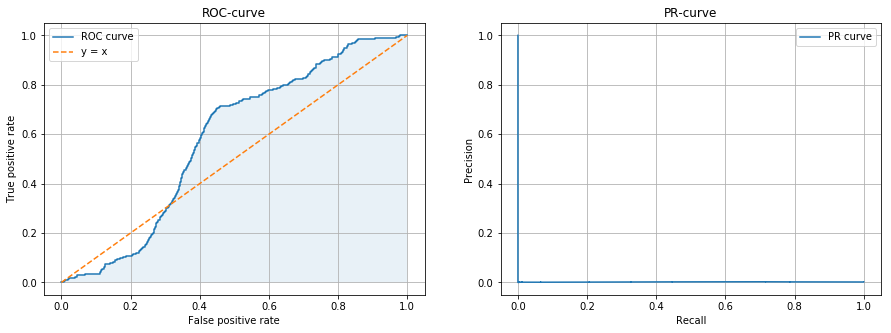

ROC-AUC = 0.5778
PR-AUC = 0.002044


In [18]:
ROC_PR(test_y, clf1.predict_proba(test_x)[:, 1])

### 3.2 AdaBoost whith bagging

In [19]:
from imblearn.ensemble import EasyEnsembleClassifier

In [20]:
clf2 = EasyEnsembleClassifier(n_estimators = 100, n_jobs = 8)
clf2.fit(train_x, train_y)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=8,
            random_state=None, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)

In [21]:
pred2 =  clf2.predict(test_x)

In [22]:
stats(test_y, pred2)

Accuracy:  0.806540646502
Precision:  0.00591782295846
Recall:  0.619718309859
Fscore:  0.0117236938517
MSE:  0.193459353498


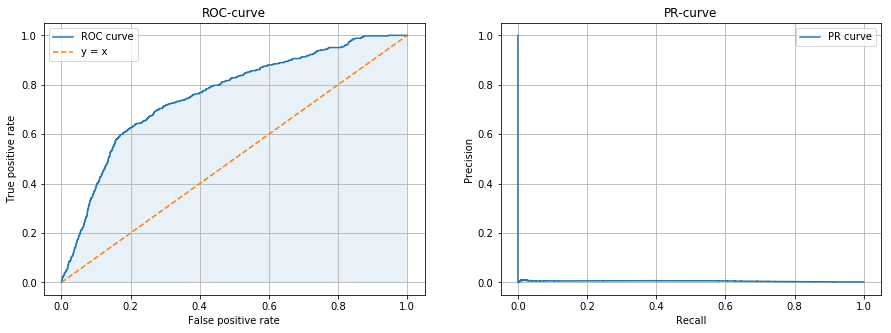

ROC-AUC = 0.759
PR-AUC = 0.005581


In [23]:
ROC_PR(test_y, clf2.predict_proba(test_x)[:, 1])

### 3.3 RandomForest whith balancing

In [24]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [37]:
clf3 = BalancedRandomForestClassifier(n_estimators = 200, n_jobs = 8)
clf3.fit(train_x, train_y)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [38]:
pred3 =  clf3.predict(test_x)

In [39]:
stats(test_y, pred3)

Accuracy:  0.886877415036
Precision:  0.00685775928494
Recall:  0.417840375587
Fscore:  0.0134940489728
MSE:  0.113122584964


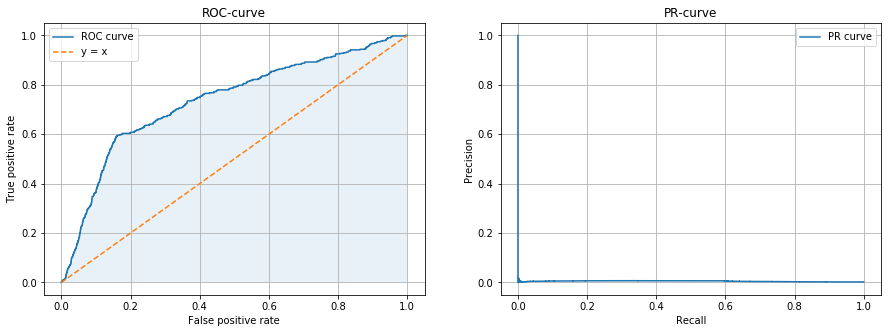

ROC-AUC = 0.7355
PR-AUC = 0.00522


In [40]:
ROC_PR(test_y, clf3.predict_proba(test_x)[:, 1])

### 4. Conclusion.
Unfortunately our experiment is unsuccessful. It seems impossible to obtain good precision score on choosen dataset. Probably it is due to huge level of imbalancing (less than 0.1% elements belongs to positive class) and relatevly small data sample (which is specified by really time consuming features construction process and limited number of possible rows in training dataset).  

However classifers which utilise balancing technicues demonstrates little better perfomance, than standart ones.